In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable
import torch.nn.functional as F

import numpy as np

In [2]:
#get data

from data_utils import load_mnist

trX, teX, trY, teY = load_mnist(onehot=False)

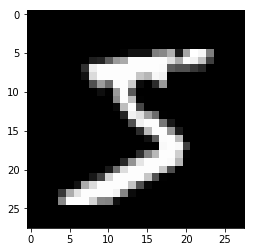

In [3]:
#view data

import matplotlib.pyplot as plt

plt.imshow(trX[0].reshape(28,28), cmap=plt.get_cmap('gray')) #need cmap thing or else is weird colour
plt.show()

In [4]:
#convert from numpy arrays to torch tensors

trX = torch.from_numpy(trX).float()
teX = torch.from_numpy(teX).float()
trY = torch.from_numpy(trY).long()
teY = torch.from_numpy(teY).long()

print(trX.shape)

torch.Size([60000, 784])


In [5]:
#create model

class Net(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(Net, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.i2h = nn.Linear(input_size, hidden_size)
        self.h2h = nn.Linear(hidden_size, hidden_size)
        self.h2o = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = F.relu(self.i2h(x))
        x = F.relu(self.h2h(x))
        x = self.h2o(x)
        return F.softmax(x)

In [6]:
#define loss functions

class REINFORCE(torch.nn.Module):
    """
    REINFORCE Function
    -(r-b)*log(p_i)
    
    From https://www.quora.com/What-is-the-REINFORCE-algorithm:
    "Basically it increases the probability that a policy will make a rewarding action given a state."
    
    Your policy here is your neural network.
    The state is the input.
    The action is the output.
    
    http://www-anw.cs.umass.edu/~barto/courses/cs687/williams92simple.pdf
    http://www.scholarpedia.org/article/Policy_gradient_methods
    https://stats.stackexchange.com/questions/137246/any-example-code-of-reinforce-algorithm-proposed-by-williams
    https://stats.stackexchange.com/questions/239502/deriving-reinforce-algorithm-from-policy-gradient-theorem-for-the-episodic-case
    """

    def __init__(self, negative_rewards=False):
        super(REINFORCE, self).__init__()
        self.negative_rewards = negative_rewards

    def forward(self, outputs, labels):
        values, predictions = torch.max(outputs, 1) #what the network predicts the digit is
        if self.negative_rewards:
            pos_reward = (predictions == labels).float() #how many it got right, need to cast from bytetensor to floattensor
            neg_reward = (predictions != labels).float()*(-1)
            reward = pos_reward + neg_reward
        else:
            reward = (predictions == labels).float()
        baseline = reward.sum()/len(labels) #proportion it got right, i.e average reward
        adv = reward - baseline #advantage
        logit = torch.log(values)
        loss = -adv*logit #loss = -(r-b)*grad(log(pi))

        return loss.sum()/len(labels), reward.sum()/len(labels)

In [7]:
#create instance of Net class

net = Net(784, 100, 10)

In [8]:
#define some parameters

epochs = 10
batch_size = 32
learning_rate = 0.001
momentum = 0.9

In [9]:
#define loss and optimizer

criterion = REINFORCE(negative_rewards=True)
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

In [10]:
#training function

def train(model, criterion, optimizer, x, y):
    x = Variable(x, requires_grad=False)
    y = Variable(y, requires_grad=False)
    
    # Reset gradient
    optimizer.zero_grad()

    # Forward
    fx = model.forward(x)
    
    loss, reward = criterion(fx, y)

    # Backward
    loss.backward()

    # Update parameters
    optimizer.step()

    return loss.data[0], reward.data[0]

In [11]:
#make predictions

def predict(model, x, y):
    x = Variable(x, requires_grad=False)
    outputs = model(x)
    _, predicted = torch.max(outputs.data, 1) #for each output, get the predicted value (torch.max returns (index, value) tuple)
    correct = (predicted == y) #how many predicted values equal the labels
    return correct.sum() 

In [12]:
#run the training

num_examples = trX.shape[0]
num_batches = num_examples // batch_size

for e in range(1, epochs+1):
    loss, reward = 0, 0
    for k in range(num_batches):
        start, end = k * batch_size, (k + 1) * batch_size
        loss_batch, reward_batch = train(net, criterion, optimizer, trX[start:end], trY[start:end])
        loss += loss_batch
        reward += reward_batch
    correct = predict(net, teX, teY)

    print("Epoch %02d, loss = %f, avg. reward = %f, accuracy = %.2f%%" % (e, loss / num_batches, reward / num_batches, correct/teX.shape[0]*100))

Epoch 01, loss = -2.399233, avg. reward = 5.531000, accuracy = 85.05%
Epoch 02, loss = -2.966393, avg. reward = 7.587000, accuracy = 88.41%
Epoch 03, loss = -3.012029, avg. reward = 7.910333, accuracy = 91.32%
Epoch 04, loss = -2.865003, avg. reward = 8.149667, accuracy = 92.44%
Epoch 05, loss = -2.677641, avg. reward = 8.343000, accuracy = 91.75%
Epoch 06, loss = -2.655949, avg. reward = 8.419000, accuracy = 92.96%
Epoch 07, loss = -2.571174, avg. reward = 8.506000, accuracy = 93.00%
Epoch 08, loss = -2.526717, avg. reward = 8.554667, accuracy = 93.67%
Epoch 09, loss = -2.423262, avg. reward = 8.641667, accuracy = 93.74%
Epoch 10, loss = -2.415782, avg. reward = 8.665000, accuracy = 93.27%
